## Analysis and Filtering of metabolism data: Dapsone

##### Author: Matthew W. Boyce, PhD, 
##### Email: boyce.matthew@epa.gov

##### Version: 2.0 09-29-2021

##### Description:  
This notebook was developed to:
1. Read in the output of the NTA WebAPP data, which has processed in vitro metabolism data of the parent compound
2. Filter out features that do not have a fold-change value > 1.5, and are measured in two time points where the fold-change cutoff is met
3. Cluster the filtered features based on the standardized signal across the conditions and tim epoints
4. Extract and export: the parent feature and clusters that contain suspected metabolites (based on annotation)

##### Notes: This script uses os, pandas, numpy, matplotlib, rdkit, scipy, skleanr, networkx, seaborn, math, warnings

##### Potential issues: *None known*




## Table of Contents

1) Initialize
2) Read and Prepare Data
3) Filter on FC
4) 

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm, Normalize
import networkx as nx
import scipy as scipy
import os
import seaborn as sns
import math

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE, MDS
from sklearn import preprocessing

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import nxviz as nv 
from nxviz import annotate

from rdkit import Chem


#### Set general variables related to in vitro data

In [6]:
timePoints = [0,1,4]
sampleConditions = ['Super','Gluc','Pellet']
parentFormula = 'C12H12N2O2S'
saveFiles = False

#### Set directory
- RootDir: Where the project is stored
- figDir: Where figures will be stored
- ResultDir: Where the final feature list will be stored

In [7]:
rootDir = r'L:\Lab\NCCT_ExpoCast\ExpoCast2020\SSA-Metabolism\CaseStudy\Dapsone_CaseStudy'
figDir = rootDir + '\Figures\DataReview'
if not os.path.exists(figDir):
    os.makedirs(figDir)
    
resultDir = rootDir + r'\Filtered_features'
if not os.path.exists(resultDir):
    os.makedirs(resultDir)

### Set helper functions

In [8]:
def optimize_kmeans(input_df, input_clusters):
    cluster_list = list(range(1, input_clusters+1))
    wcss = []
    sil = []
    
    for cluster in cluster_list:
        kmeans = KMeans(n_clusters=cluster, random_state=0).fit(input_df)
        wcss.append(kmeans.inertia_)
        try:
            ss = silhouette_score(input_df, kmeans.labels_ , metric = 'euclidean')
        except:
            ss = 0
        sil.append(ss)
        
    fig, ax1 = plt.subplots(figsize=(6,6))

    ax1.plot(range(1, input_clusters+1), wcss)
    ax2 = ax1.twinx()
    ax2.plot(range(1, input_clusters+1), sil, color = 'red')
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.show()
    return(wcss)

# This performs clustering at the feature level (or whatever is separated into rows in the input excel file)
# It takes in the input file, and the desired k number of clusters to perform k means clustering with (i.e. the optimized value from the optimize_kmeans function/elbow method)

def do_kmeans_feature(input_df, input_clusters):
    #Cluster the data
    kmeans = KMeans(n_clusters=input_clusters, n_init=100, random_state=0).fit(input_df)
    labels = kmeans.labels_
    index_list = input_df.index.tolist()
    return_df = pd.DataFrame()
    return_df['Feature_ID'] = index_list
    return_df['Feature_ID'] = return_df['Feature_ID'].astype(int)
    return_df['kmeans_cluster'] = labels

    return(return_df)

# This performs clustering at the sample level (or whatever is separated into columns in the input excel file)
# It takes in the input file, and the desired k number of clusters to perform k means clustering with (i.e. the optimized value from the optimize_kmeans function/elbow method)

def do_kmeans_sample(input_df, input_clusters):
    #Cluster the data
    kmeans = KMeans(n_clusters=input_clusters, n_init=100, random_state=0).fit(input_df)
    labels = kmeans.labels_
    index_list = input_df.index.tolist()
    return_df = pd.DataFrame()
    return_df['Feature_ID'] = index_list
    return_df['kmeans_cluster'] = labels
    
    return(return_df)

In [9]:
def CatchZeroDivision(x,y):
    xf = float(x)
    yf = float(y)
    if(xf==0 and yf==0):
        return 1
    elif(xf == 0):
        return -math.inf
    elif(yf == 0):
        return math.inf
    else:
        return xf/yf
    
def CatchZeroDivision_Series(x_series,y_series):
    returnList = []
    for x,y in zip(x_series, y_series):
        returnList.append(CatchZeroDivision(x, y))
    return returnList

In [10]:
def plotClusterMap(dataToPlot, n_clusters, annotatedDF, column_annotations = True, parentFormula = None, *args, **kwargs):
    
    sns.set(font_scale=1)
    columnsToPlot = dataToPlot.columns
    
    kmeans = KMeans(n_clusters= n_clusters, n_init=100, random_state=0).fit(dataToPlot)
    clustering = AgglomerativeClustering(n_clusters = n_clusters).fit(dataToPlot)
    
    dataToPlot['kmeans'] = kmeans.labels_
    dataToPlot['clustering'] = clustering.labels_
    dataToPlot['Annotated'] = annotatedDF['Annotation_Source']

    dataToPlot.sort_values(by = ['kmeans', 'clustering'], inplace = True)
    
    if column_annotations == True:
        lut1 = dict(zip(set(kmeans.labels_), sns.hls_palette(len(set(kmeans.labels_)), l=0.5, s=1)))
        lut2 = {'MFG' : 'skyblue', 'Parent': 'black', 'Suspect': 'green', 'BPM': 'red'}
        kwargs['row_colors'] = [dataToPlot['kmeans'].map(lut1), dataToPlot['Annotated'].map(lut2)]
    
    g = sns.clustermap(dataToPlot[columnsToPlot], **kwargs)

### Import Data
- rawDataFile: Output of the NTA WebApp, after individual conditions are merged into a single csv
- screeningDataFile: File containing all suspected metabolites of Haloperidol used for feature annotation

In [11]:
rawDataFile = rootDir + r'\WebApp_Combined\WebApp_Results_combined.csv'
rawData = pd.read_csv(rawDataFile)

In [12]:
screeningDataFile = rootDir + r'\PCDL\Compound_Import.csv'
screeningData = pd.read_csv(screeningDataFile, comment = '#')

### Read-in and review data

In [13]:
rawData

,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,Gluc01,...,BlankS41,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info
0,1572,C10H10N4O5S_mfg,74.06,298.0373,0.532000,NaN,NaN,NaN,375050.0,297300.0,...,NaN,NaN,960085.0,946966.0,729639.0,946966.0,946966.0,0,0,NaN
1,1530,C10H13N5O41.615,78.15,267.0972,1.615000,NaN,NaN,NaN,174184.0,77114.0,...,NaN,NaN,1125854.0,1084227.0,732181.0,1084227.0,1084227.0,0,0,NaN
2,145,C10H13NO37.391999_mfg,99.56,195.0899,7.391999,NaN,NaN,NaN,276419.0,298315.0,...,NaN,NaN,285546.0,293213.0,289482.0,289482.0,289482.0,0,0,NaN
3,287,C10H14N4O5_mfg,96.24,270.0958,0.501000,NaN,NaN,NaN,59463.0,17486.0,...,NaN,NaN,169796.0,138833.0,34054.0,138833.0,138833.0,0,0,NaN
4,565,C10H16Cl2N4O8S_mfg,95.66,422.0041,0.467000,NaN,NaN,NaN,195149.0,135293.0,...,NaN,NaN,368769.0,135311.0,293103.0,293103.0,293103.0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,1008,C28H40N9O6S4_mfg,79.39,726.1996,3.923001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100458.0,99848.0,39919.0,99848.0,99848.0,0,0,NaN
915,1101,C33H20N15O10_mfg,68.81,785.1544,4.647998,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,164095.0,150109.0,27174.0,150109.0,150109.0,0,0,NaN
916,77,C4HClNS2_mfg,45.51,161.9446,0.461000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,148847.0,142004.0,112124.0,142004.0,142004.0,0,0,NaN
917,37,C6H10O31.7610009,87.31,130.0630,1.761001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,247487.0,220300.0,123087.0,220300.0,220300.0,0,0,NaN


#### Remove adducts from data

In [14]:
rawData = rawData[rawData['Is_Adduct_or_Loss'] == 0]
rawData

,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,Gluc01,...,BlankS41,BlankS42,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info
0,1572,C10H10N4O5S_mfg,74.06,298.0373,0.532000,NaN,NaN,NaN,375050.0,297300.0,...,NaN,NaN,960085.0,946966.0,729639.0,946966.0,946966.0,0,0,NaN
1,1530,C10H13N5O41.615,78.15,267.0972,1.615000,NaN,NaN,NaN,174184.0,77114.0,...,NaN,NaN,1125854.0,1084227.0,732181.0,1084227.0,1084227.0,0,0,NaN
2,145,C10H13NO37.391999_mfg,99.56,195.0899,7.391999,NaN,NaN,NaN,276419.0,298315.0,...,NaN,NaN,285546.0,293213.0,289482.0,289482.0,289482.0,0,0,NaN
3,287,C10H14N4O5_mfg,96.24,270.0958,0.501000,NaN,NaN,NaN,59463.0,17486.0,...,NaN,NaN,169796.0,138833.0,34054.0,138833.0,138833.0,0,0,NaN
4,565,C10H16Cl2N4O8S_mfg,95.66,422.0041,0.467000,NaN,NaN,NaN,195149.0,135293.0,...,NaN,NaN,368769.0,135311.0,293103.0,293103.0,293103.0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,1008,C28H40N9O6S4_mfg,79.39,726.1996,3.923001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100458.0,99848.0,39919.0,99848.0,99848.0,0,0,NaN
915,1101,C33H20N15O10_mfg,68.81,785.1544,4.647998,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,164095.0,150109.0,27174.0,150109.0,150109.0,0,0,NaN
916,77,C4HClNS2_mfg,45.51,161.9446,0.461000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,148847.0,142004.0,112124.0,142004.0,142004.0,0,0,NaN
917,37,C6H10O31.7610009,87.31,130.0630,1.761001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,247487.0,220300.0,123087.0,220300.0,220300.0,0,0,NaN


## Report Annotated Features

In [15]:
rawData['Annotation_Source'] = 'MFG'

In [16]:
cleanedFormula = []
for formula in rawData['Formula']:
    tmpFormula = formula
    if 'Esi' in formula:
        tmpFormula = formula.split('Esi')[0]
    if '.' in tmpFormula:
        tmpFormula = tmpFormula.split('.')[0][:-1]
    if '_mfg' in tmpFormula:
        tmpFormula = tmpFormula.split('_mfg')[0]
    cleanedFormula += [tmpFormula]
rawData['Formula_Clean'] = cleanedFormula

#### Parent Data

In [17]:
rawData.loc[rawData['Formula'] == parentFormula,'Annotation_Source'] = 'Parent'
parentDataAll = rawData.loc[rawData['Formula'] == parentFormula,]
parentData = rawData.loc[rawData['Formula'] == parentFormula,['BlankSub_Median_Super0','BlankSub_Median_Super1','BlankSub_Median_Super4',
                                                            'BlankSub_Median_Gluc0','BlankSub_Median_Gluc1','BlankSub_Median_Gluc4',
                                                            'BlankSub_Median_Pellet0','BlankSub_Median_Pellet1','BlankSub_Median_Pellet4',]].values

In [18]:
parentDataAll

,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,Gluc01,...,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info,Annotation_Source,Formula_Clean
22,1516,C12H12N2O2S,95.88,248.0633,2.706,NaN,NaN,NaN,7342863.0,8434373.0,...,3218058.0,6223036.0,13041058.0,6223036.0,6223036.0,0,0,NaN,Parent,C12H12N2O2S


#### Metab features

In [19]:
rawData.update(
    rawData.loc[(rawData['Formula_Clean'].isin(screeningData[' Formula'])) & (rawData['Annotation_Source'] != 'Parent'), 'Annotation_Source'].replace({'MFG':'Suspect'}))
metabDF = rawData[rawData['Annotation_Source'] == 'Suspect'].reset_index()

In [20]:
metabDF

,index,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,...,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info,Annotation_Source,Formula_Clean
0,32,464,C12H8N2O6S0.48800033,68.06,354.0146,0.488,NaN,NaN,NaN,316026.0,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,Suspect,C12H8N2O6S
1,257,280,C12H10O5S0.81399953,67.43,266.0265,0.814,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,Suspect,C12H10O5S
2,262,468,C13H12N2O5S4.9069996,54.77,354.0564,4.907,NaN,NaN,NaN,NaN,...,74396.0,75119.0,33079.0,74396.0,74396.0,0,0,NaN,Suspect,C13H12N2O5S
3,872,401,C14H14N2O5S,57.55,322.0624,0.549,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,Suspect,C14H14N2O5S


#### Blood Plasma Metabs

In [21]:
rawData.update(
    rawData.loc[(~rawData['Formula'].str.contains('_mfg')) & (rawData['Annotation_Source'] == 'MFG'), 'Annotation_Source'].replace({'MFG':'BPM'}))
plasmaMetabDF = rawData[rawData['Annotation_Source'] == 'BPM'].reset_index()

In [22]:
plasmaMetabDF

,index,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,...,Super40,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info,Annotation_Source,Formula_Clean
0,1,1530,C10H13N5O41.615,78.15,267.0972,1.615000,NaN,NaN,NaN,174184.0,...,1125854.0,1084227.0,732181.0,1084227.0,1084227.0,0,0,NaN,BPM,C10H13N5O4
1,9,1454,C10H9NO1.9690012,87.72,159.0677,1.969001,NaN,NaN,NaN,504506.0,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,BPM,C10H9NO
2,12,1480,C11H12N2O21.8430005,85.61,204.0894,1.843001,NaN,NaN,NaN,1029288.0,...,4217349.0,4223932.0,1728461.0,4217349.0,4217349.0,0,0,NaN,BPM,C11H12N2O2
3,13,196,C11H12N2O36.8269978,86.38,220.0835,6.826998,NaN,NaN,NaN,760738.0,...,761986.0,749768.0,826395.0,761986.0,761986.0,0,0,NaN,BPM,C11H12N2O3
4,21,263,C12H10O4S12.909995,41.80,250.0289,12.909995,NaN,NaN,NaN,44454.0,...,39849.0,43693.0,38903.0,39849.0,39849.0,0,0,NaN,BPM,C12H10O4S1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,869,124,C7H7NO21.2099993,96.00,183.0529,1.209999,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,BPM,C7H7NO2
63,870,1458,C9H11NO21.0099994,87.74,165.0789,1.009999,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,NaN,BPM,C9H11NO2
64,909,166,C10H11NO,82.55,207.0894,4.294999,NaN,NaN,NaN,NaN,...,48755.0,48170.0,24070.0,48170.0,48170.0,0,0,NaN,BPM,C10H11NO
65,910,1462,C10H13NO22.88,87.13,179.0951,2.880000,NaN,NaN,NaN,NaN,...,837668.0,858428.0,698483.0,837668.0,837668.0,0,0,NaN,BPM,C10H13NO2


### Clean and Prepare Data

#### Impute and Normalize data

In [23]:
noiseValue = 10000

In [24]:
dataColumns = ['BlankSub_Median_Super0', 'BlankSub_Median_Super1', 'BlankSub_Median_Super4',
               'BlankSub_Median_Gluc0', 'BlankSub_Median_Gluc1', 'BlankSub_Median_Gluc4',
               'BlankSub_Median_Pellet0', 'BlankSub_Median_Pellet1', 'BlankSub_Median_Pellet4']

In [25]:
noiseImpute = rawData[dataColumns].replace(np.nan, 10000.0).copy()
noiseImpute_transform = noiseImpute.apply(lambda x: np.log2(x), axis = 1)
noiseImpute_normalized = noiseImpute_transform.apply(lambda x: (x - x.mean())/x.std(), axis = 1)

In [26]:
noiseImpute.describe()

,BlankSub_Median_Super0,BlankSub_Median_Super1,BlankSub_Median_Super4,BlankSub_Median_Gluc0,BlankSub_Median_Gluc1,BlankSub_Median_Gluc4,BlankSub_Median_Pellet0,BlankSub_Median_Pellet1,BlankSub_Median_Pellet4
count,8.870000e+02,8.870000e+02,8.870000e+02,8.870000e+02,8.870000e+02,8.870000e+02,8.870000e+02,8.870000e+02,8.870000e+02
mean,5.577807e+05,4.261565e+05,4.375845e+05,3.809495e+05,5.717850e+05,2.885005e+05,6.189973e+05,6.859700e+05,9.920373e+05
std,3.733684e+06,2.642911e+06,3.166921e+06,3.208256e+06,4.255384e+06,2.152590e+06,4.066029e+06,4.527865e+06,5.187707e+06
min,1.000000e+04,1.000000e+04,9.304000e+03,1.000000e+04,9.797000e+03,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
25%,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
50%,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,4.534900e+04
75%,6.213700e+04,6.217650e+04,2.153400e+04,3.097950e+04,5.921650e+04,1.000000e+04,1.173120e+05,1.141085e+05,3.313185e+05
max,6.254620e+07,5.993892e+07,6.109557e+07,8.647287e+07,9.040750e+07,4.902014e+07,7.889729e+07,7.583933e+07,7.014038e+07


In [27]:
fcImpute = rawData.loc[:,dataColumns].replace(np.nan, 0.0).copy()
for condition in sampleConditions:
    fcImpute[[x for x in fcImpute.columns if condition in x]] =  fcImpute[[x for x in fcImpute.columns if condition in x]].apply(lambda x: CatchZeroDivision_Series(x, fcImpute['BlankSub_Median_'+condition+'0']))

In [28]:
fcLowImputeValues = fcImpute.apply(lambda x: min(x.replace(-math.inf, 10000)), axis = 0)
fcHighImputeValues = fcImpute.apply(lambda x: max(x.replace(math.inf, -10000)), axis = 0)

fcImpute = fcImpute.replace(-math.inf, min(fcLowImputeValues)).replace(math.inf, max(fcHighImputeValues))

In [29]:
minFCValue = 1.5
minFC_Filter = fcImpute.apply(lambda row: max(row) >= minFCValue, axis = 1)
minFCParent_Filter = (minFC_Filter) | (rawData['Formula'] == parentFormula)

In [30]:
fcImpute_transform = fcImpute.apply(lambda x: np.log2(x), axis = 1)
fcImpute_normalized = fcImpute_transform.apply(lambda x: (x - x.mean())/x.std(), axis = 1)

In [31]:
fcImpute.describe()

,BlankSub_Median_Super0,BlankSub_Median_Super1,BlankSub_Median_Super4,BlankSub_Median_Gluc0,BlankSub_Median_Gluc1,BlankSub_Median_Gluc4,BlankSub_Median_Pellet0,BlankSub_Median_Pellet1,BlankSub_Median_Pellet4
count,887.0,887.000000,887.000000,887.0,887.000000,887.000000,887.0,887.000000,887.000000
mean,1.0,1.924455,1.772433,1.0,2.765977,1.394270,1.0,2.224209,4.981278
std,0.0,3.624707,3.446690,0.0,4.709670,2.502830,0.0,4.238476,6.361297
min,1.0,0.072023,0.072023,1.0,0.072023,0.072023,1.0,0.072023,0.072023
25%,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,0.880912,1.000000
50%,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,1.000000
75%,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.000000,14.859908
max,1.0,14.859908,14.859908,1.0,14.859908,14.859908,1.0,14.859908,14.859908


#### Filter on Fold-Change: remove features that have a fc > 1.5 for any condition and at least two measurements in that condition

In [32]:
columnGroups = []
for condition in sampleConditions:
    columnGroups +=  [[x for x in dataColumns if condition in x]]

In [33]:
filterConditionDF = pd.DataFrame()
filterConditionDF['Super'] = rawData[columnGroups[0]].applymap(lambda x: not math.isnan(x)).apply(lambda x: sum(x) >= 2, axis = 1) &  fcImpute[columnGroups[0]].apply(lambda row: max(row) >= minFCValue, axis = 1)
filterConditionDF['Gluc'] = rawData[columnGroups[1]].applymap(lambda x: not math.isnan(x)).apply(lambda x: sum(x) >= 2, axis = 1) & fcImpute[columnGroups[1]].apply(lambda row: max(row) >= minFCValue, axis = 1)
filterConditionDF['Pellet'] = rawData[columnGroups[2]].applymap(lambda x: not math.isnan(x)).apply(lambda x: sum(x) >= 2, axis = 1) & fcImpute[columnGroups[2]].apply(lambda row: max(row) >= minFCValue, axis = 1)

In [34]:
FCandSampleCountFilter = (filterConditionDF.apply(lambda x: bool(sum(x)), axis = 1)) | (rawData['Formula']==parentFormula)

In [35]:
sum(FCandSampleCountFilter)

183

In [36]:
rawData_FCFilter =  rawData[FCandSampleCountFilter].copy().reset_index()

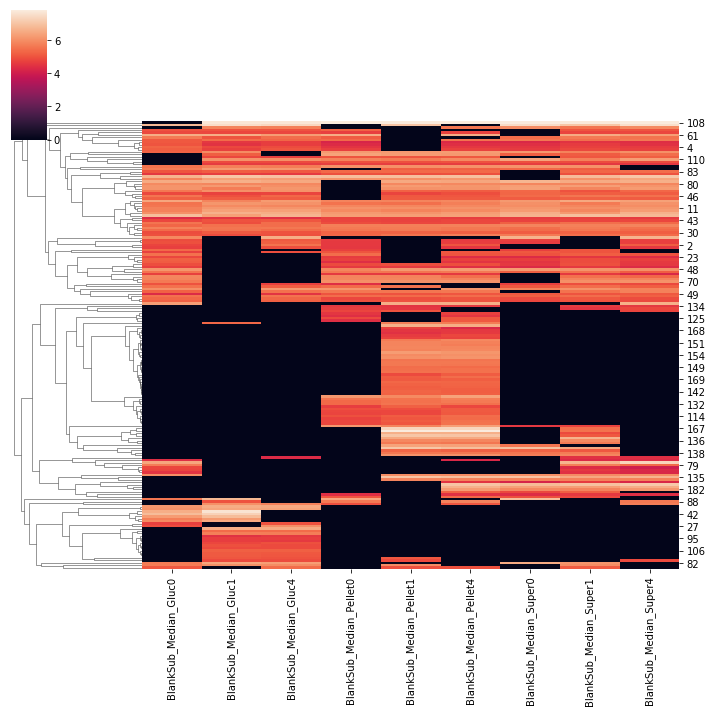

In [37]:
clusterData_FC = rawData_FCFilter[[col for col in rawData.columns if 'BlankSub_Median_' in col]].fillna(1)
clusterFigure = sns.clustermap(np.log10(clusterData_FC), col_cluster=False)

## Tracking Parent Response

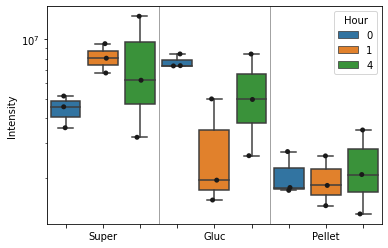

In [38]:
columns = ['Super00', 'Super01', 'Super02', 'Super10', 'Super11', 'Super12', 'Super40', 'Super41', 'Super42', 'Gluc00', 'Gluc01', 'Gluc02', 'Gluc10', 'Gluc11', 'Gluc12', 'Gluc40', 'Gluc41', 'Gluc42', 'Pellet00', 'Pellet01', 'Pellet02', 'Pellet10', 'Pellet11', 'Pellet12', 'Pellet40', 'Pellet41', 'Pellet42']
conditionGroups = [x[:-1] for x in columns]
timeGroups = [x[-2] for x in columns]

fig, axes = plt.subplots(nrows=1, ncols=len(parentDataAll[columns].values))

if len(parentDataAll[columns].values) == 1:
        plotDF = pd.DataFrame()
        plotDF['Condition'] = conditionGroups
        plotDF['Intensity'] = parentDataAll[columns].values[0]
        plotDF['Hour'] = timeGroups

        sns.boxplot(data = plotDF, x = 'Condition', y = 'Intensity', hue = 'Hour', dodge=False, whis=np.inf, ax = axes)
        sns.stripplot(data = plotDF, x = 'Condition', y = 'Intensity', color = ".1", ax = axes)

        axes.set_xlabel('')
        axes.set_yscale("log")
        axes.set(xticklabels=['','Super','','','Gluc','','','Pellet',''])
        axes.add_patch(mpatches.Rectangle((0, 0), 1/3, 1, fill=False, transform=axes.transAxes, alpha = 0.2)) 
        axes.add_patch(mpatches.Rectangle((1/3, 0), 1/3, 1, fill=False, transform=axes.transAxes, alpha = 0.2)) 
        axes.add_patch(mpatches.Rectangle((2/3, 0), 1/3, 1, fill=False, transform=axes.transAxes, alpha = 0.2)) 

else:
    for idx, ax in enumerate(axes):
        plotDF = pd.DataFrame()
        plotDF['Condition'] = conditionGroups
        plotDF['Intensity'] = parentDataAll[columns].values[idx]
        plotDF['Hour'] = timeGroups

        sns.boxplot(data = plotDF, x = 'Condition', y = 'Intensity', hue = 'Hour', dodge=False, whis=np.inf, ax = ax)
        sns.stripplot(data = plotDF, x = 'Condition', y = 'Intensity', color = ".1", ax = ax)

        ax.set_xlabel('')
        ax.set_yscale("log")
        ax.set(xticklabels=['','Super','','','Gluc','','','Pellet',''])
        ax.add_patch(mpatches.Rectangle((0, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 
        ax.add_patch(mpatches.Rectangle((1/3, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 
        ax.add_patch(mpatches.Rectangle((2/3, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 

if saveFiles:
    plt.savefig(figDir+'\Parent_boxplot.png', dpi = 300)

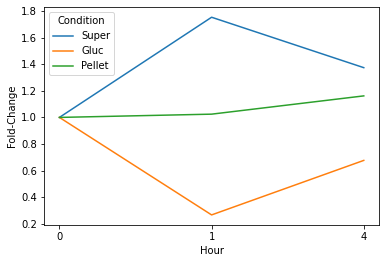

In [39]:
plotDF = fcImpute[rawData['Formula'] == parentFormula].transpose()
parentCols = plotDF.columns
plotDF['Condition'] = [x.split("_")[-1][:-1] for x in plotDF.index]
plotDF['Hour'] = [x[-1] for x in plotDF.index]

fig, axes = plt.subplots(nrows=1, ncols=len(parentCols))

if len(parentCols) == 1:
    sns.lineplot(data = plotDF, x = 'Hour', y = plotDF[parentCols[0]], hue = 'Condition', ax = axes)
    axes.set_ylabel('Fold-Change')

else:
    for idx, ax in enumerate(axes):
        sns.lineplot(data = plotDF, x = 'Hour', y = plotDF[parentCols[idx]], hue = 'Condition', ax = ax)
        ax.set_ylabel('Fold-Change')

if saveFiles:
    plt.savefig(figDir+'\Parent_fc.png', dpi = 300)

### Data Analysis: K-means clustering of filtered features

#### K-means clustering

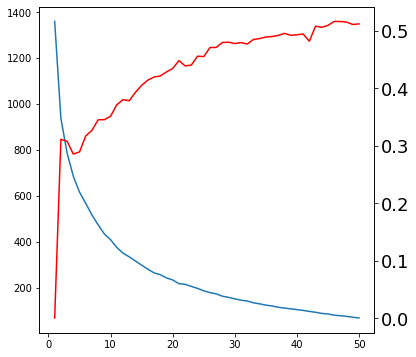

In [40]:
test_optimize = optimize_kmeans(noiseImpute_normalized[FCandSampleCountFilter], 50)
if saveFiles:
    plt.savefig(figDir+'\kmeans_opti_noiseImpute.png', dpi = 300)

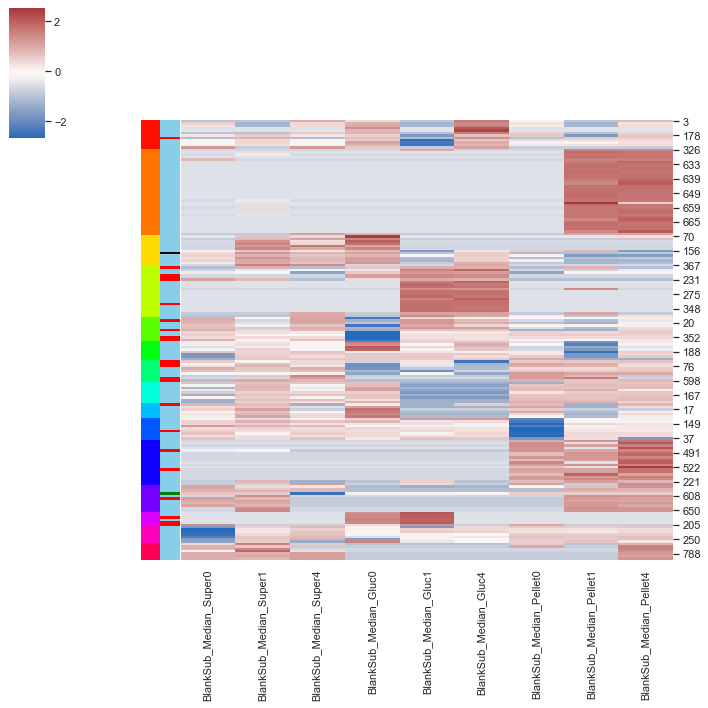

In [41]:
plotClusterMap(noiseImpute_normalized[FCandSampleCountFilter], 15, rawData, cmap='vlag', parentFormula = 'C21H23ClFNO2', row_cluster = False, col_cluster = False)
if saveFiles:
    plt.savefig(figDir + r'\cluster_noiseImpute.png', dpi = 600)

### Features in K-means cluster

In [42]:
kmeans = KMeans(n_clusters= 15, n_init=100, random_state=0).fit(noiseImpute_normalized[FCandSampleCountFilter])
rawData_FCFilter['KMeans'] = kmeans.labels_

In [43]:
rawData_FCFilter

,index,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,...,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info,Annotation_Source,Formula_Clean,KMeans
0,0,1572,C10H10N4O5S_mfg,74.06,298.0373,0.532000,NaN,NaN,NaN,375050.0,...,946966.0,729639.0,946966.0,946966.0,0,0,NaN,MFG,C10H10N4O5S,4
1,1,1530,C10H13N5O41.615,78.15,267.0972,1.615000,NaN,NaN,NaN,174184.0,...,1084227.0,732181.0,1084227.0,1084227.0,0,0,NaN,BPM,C10H13N5O4,6
2,3,287,C10H14N4O5_mfg,96.24,270.0958,0.501000,NaN,NaN,NaN,59463.0,...,138833.0,34054.0,138833.0,138833.0,0,0,NaN,MFG,C10H14N4O5,0
3,5,591,C10H21ClO14S0.45299968_mfg,98.08,432.0332,0.453000,NaN,NaN,NaN,310161.0,...,98126.0,146227.0,98126.0,98126.0,0,0,NaN,MFG,C10H21ClO14S,8
4,7,524,C10H2N4O11S0.43799984_mfg,86.50,385.9429,0.438000,NaN,NaN,NaN,193783.0,...,40237.0,61996.0,41651.0,41651.0,0,0,NaN,MFG,C10H2N4O11S,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,676,677,C14H18Cl2N3O8S20.45800015_mfg,96.38,489.9918,0.458000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,MFG,C14H18Cl2N3O8S2,14
179,680,886,C16H27ClNO15S4_mfg,87.93,635.9956,0.446000,NaN,NaN,NaN,NaN,...,17750.0,40568.0,17750.0,17750.0,0,0,NaN,MFG,C16H27ClNO15S4,14
180,788,1990,C38H78N6O2S12.796998_mfg,96.22,682.5901,12.796998,NaN,NaN,NaN,NaN,...,4327610.0,3717574.0,3717574.0,3717574.0,0,0,NaN,MFG,C38H78N6O2S1,14
181,791,2007,C38H81N7O2S12.794004_mfg,99.21,699.6171,12.794004,NaN,NaN,NaN,NaN,...,12717354.0,4035853.0,12717354.0,12717354.0,0,0,NaN,MFG,C38H81N7O2S1,14


In [44]:
rawData_FCFilter[rawData_FCFilter['Annotation_Source'].isin(['Suspect', 'Parent'])]

,index,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,...,Super41,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info,Annotation_Source,Formula_Clean,KMeans
9,22,1516,C12H12N2O2S,95.88,248.0633,2.706,NaN,NaN,NaN,7342863.0,...,6223036.0,13041058.0,6223036.0,6223036.0,0,0,NaN,Parent,C12H12N2O2S,2
14,32,464,C12H8N2O6S0.48800033,68.06,354.0146,0.488,NaN,NaN,NaN,316026.0,...,NaN,NaN,NaN,NaN,0,0,NaN,Suspect,C12H8N2O6S,11


#### Filter data using KMeans clusters

In [49]:
kmeansToFilterOn = list(set(rawData_FCFilter.loc[rawData_FCFilter['Annotation_Source'].isin(['Suspect']), 'KMeans']))
rawData_FCFilter.loc[rawData_FCFilter['KMeans'].isin(kmeansToFilterOn)|(rawData_FCFilter['Formula'].str.contains(parentFormula)),['Formula', 'Mass', 'Retention_Time', 'Annotation_Source', 'KMeans']].sort_values(by = 'Retention_Time')

,Formula,Mass,Retention_Time,Annotation_Source,KMeans
14,C12H8N2O6S0.48800033,354.0146,0.488000,Suspect,11
9,C12H12N2O2S,248.0633,2.706000,Parent,2
135,C16H33NO2_mfg,271.2502,7.791995,MFG,11
139,C19H37N11O28.041994_mfg,451.3123,8.041994,MFG,11
141,C29H12N2_mfg,388.1014,8.420005,MFG,11
138,C19H33OS_mfg,309.2273,8.480003,MFG,11
137,C18H37NO2,299.2799,8.658998,BPM,11
140,C19H40ClN8.782996_mfg,317.2830,8.782996,MFG,11
136,C17H41N710.261998_mfg,343.3393,10.261998,MFG,11
144,C31H45N2O_mfg,461.3528,10.744997,MFG,11


In [64]:
subset = rawData_FCFilter.loc[rawData_FCFilter['KMeans'].isin(kmeansToFilterOn)|(rawData_FCFilter['Formula'] == parentFormula),:].sort_values(by = 'Retention_Time').copy()
subset['Formula'] = [x.split(str(y)[:3])[0] + '_mfg' if str(y)[:3] in x else x for x, y in zip(subset['Formula'], subset['Retention_Time'])]
subset = subset[subset['Annotation_Source'] != 'BPM']
subset['orderCat'] = subset['Annotation_Source'].apply(lambda x: {'Parent':0, 'Suspect':1, 'MFG':3}[x])
subset.reset_index(inplace = True, drop = True)
subset.sort_values(by = ['orderCat', 'Formula_Clean'], inplace = True)
if saveFiles:
    subset.to_csv(resultDir + '\FeatureList_subset.csv', index = False)

In [56]:
subset

,index,Feature_ID,Formula,Score,Mass,Retention_Time,BlankG00,BlankG01,BlankG02,Gluc00,...,Super42,BlankSub_Median_Super4,BlankSub_Max_Median_ALLSamples_Super4,Has_Adduct_or_Loss,Is_Adduct_or_Loss,Adduct_or_Loss_Info,Annotation_Source,Formula_Clean,KMeans,orderCat
1,22,1516,C12H12N2O2S,95.88,248.0633,2.706000,NaN,NaN,NaN,7342863.0,...,13041058.0,6223036.0,6223036.0,0,0,NaN,Parent,C12H12N2O2S,2,0
0,32,464,C12H8N2O6S_mfg,68.06,354.0146,0.488000,NaN,NaN,NaN,316026.0,...,NaN,NaN,NaN,0,0,NaN,Suspect,C12H8N2O6S,11,1
2,606,1537,C16H33NO2_mfg,98.47,271.2502,7.791995,NaN,NaN,NaN,NaN,...,2592646.0,5120955.0,5120955.0,0,0,NaN,MFG,C16H33NO2,11,3
7,608,1626,C17H41N7_mfg,78.23,343.3393,10.261998,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,NaN,MFG,C17H41N71,11,3
5,610,1587,C19H33OS_mfg,73.20,309.2273,8.480003,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,NaN,MFG,C19H33OS,11,3
3,611,1730,C19H37N11O2_mfg,81.17,451.3123,8.041994,NaN,NaN,NaN,NaN,...,593874.0,562094.0,562094.0,0,0,NaN,MFG,C19H37N11O2,11,3
6,612,1598,C19H40ClN_mfg,83.37,317.2830,8.782996,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,NaN,MFG,C19H40ClN,11,3
4,620,1679,C29H12N2_mfg,69.17,388.1014,8.420005,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,NaN,MFG,C29H12N2,11,3
8,626,1738,C31H45N2O_mfg,73.92,461.3528,10.744997,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,0,NaN,MFG,C31H45N2O,11,3
10,174,847,C38H70N6_mfg,98.29,610.5654,12.122992,NaN,NaN,NaN,181118.0,...,355124.0,234105.0,234105.0,0,0,NaN,MFG,C38H70N61,11,3


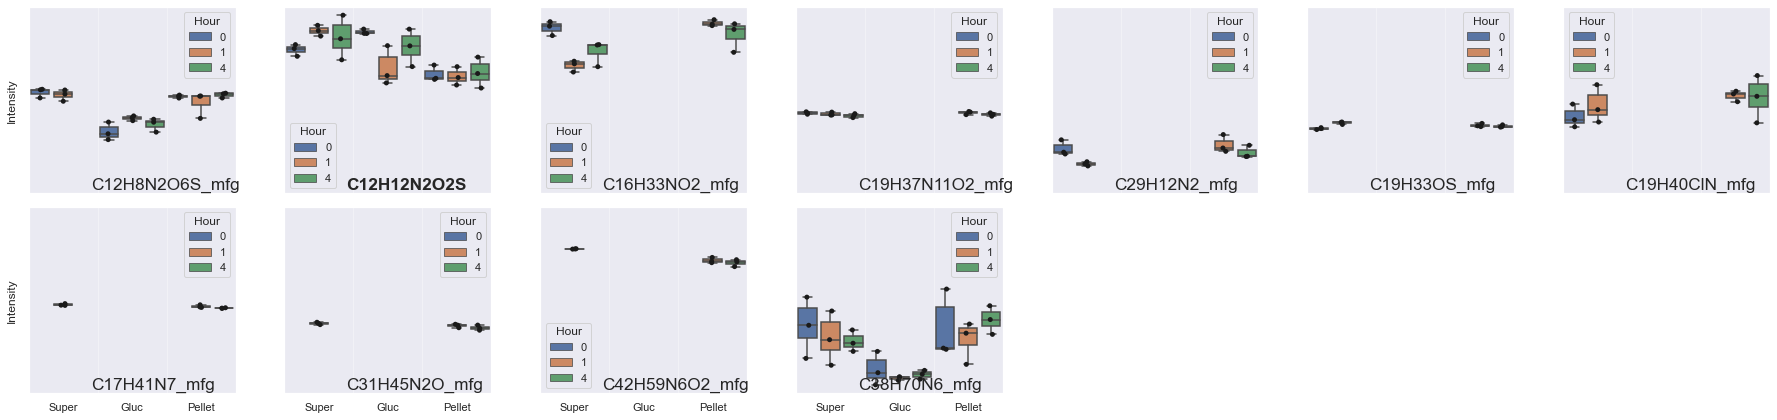

In [57]:
columns = ['Super00', 'Super01', 'Super02', 'Super10', 'Super11', 'Super12', 'Super40', 'Super41', 'Super42', 'Gluc00', 'Gluc01', 'Gluc02', 'Gluc10', 'Gluc11', 'Gluc12', 'Gluc40', 'Gluc41', 'Gluc42', 'Pellet00', 'Pellet01', 'Pellet02', 'Pellet10', 'Pellet11', 'Pellet12', 'Pellet40', 'Pellet41', 'Pellet42']
conditionGroups = [x[:-1] for x in columns]
timeGroups = [x[-2] for x in columns]
x = conditionGroups
lut = dict(zip(set(timeGroups), sns.hls_palette(len(set(timeGroups)))))
numCols = 7
numRows = math.ceil(len(subset)/numCols)
numPlots = len(subset)
fig, axes = plt.subplots(numRows, numCols, figsize = (25,int(numRows*3)), sharex = True, sharey = True)
[ax.set_axis_off() for ax in axes.ravel()]

for dfIdx, row in subset.iterrows():
    plotDF = pd.DataFrame()
    plotDF['Condition'] = conditionGroups
    plotDF['Intensity'] = row[columns].values
    plotDF['Hour'] = timeGroups
    
    subplotRow = math.floor(dfIdx/numCols)
    subplotCol = dfIdx - (numCols * subplotRow)
    
    axes[subplotRow, subplotCol].set_axis_on()
    
    ax = sns.boxplot(data = plotDF, x = 'Condition', y = 'Intensity', hue = 'Hour' , ax = axes[subplotRow, subplotCol], dodge=False, whis=np.inf)
    ax = sns.stripplot(data = plotDF, x = 'Condition', y = 'Intensity', ax = axes[subplotRow, subplotCol], color = ".1")
    
    ax.text(0.3, 0.02, row['Formula'], transform=ax.transAxes, fontsize = 'x-large', fontweight = 'regular' if '_mfg' in row['Formula'] else 'bold')
    ax.set_xlabel('')
    ax.set_yscale("log")
    ax.set(xticklabels=['','Super','','','Gluc','','','Pellet',''])
    ax.xaxis.set_major_locator(plt.FixedLocator([1,4,7]))
    
    if subplotCol != 0:
        ax.set_ylabel('')
        ax.set_yticks([], minor=False)
        #axes[subplotRow, subplotCol].tick_params(left = False)
        #axes[subplotRow, subplotCol].minorticks_off()
        
    if subplotRow != 0:
        ax.tick_params(top = False)
    
    ax.add_patch(mpatches.Rectangle((0, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 
    ax.add_patch(mpatches.Rectangle((1/3, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 
    ax.add_patch(mpatches.Rectangle((2/3, 0), 1/3, 1, fill=False, transform=ax.transAxes, alpha = 0.2)) 

fig.tight_layout()
if saveFiles:
    plt.savefig(figDir + r'\SelectedFeature_boxplot.png', dpi = 300)

### Heatmap of selected features

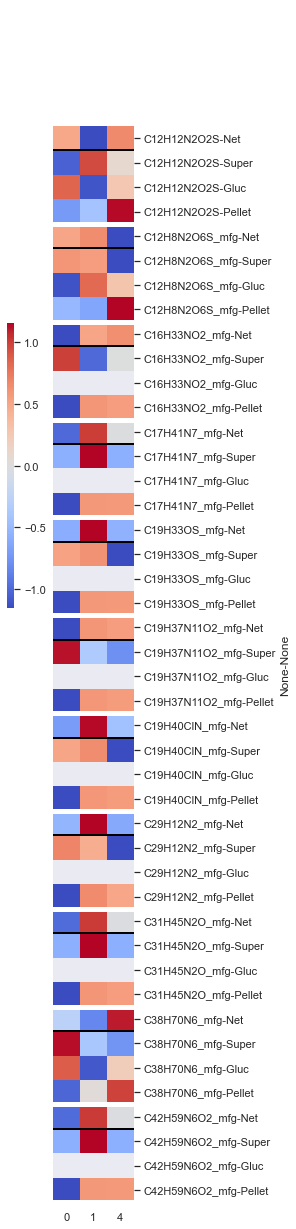

In [58]:
subsetImpute = subset[dataColumns].replace(np.nan, 10000.0).copy()
subsetImpute_transform = subsetImpute.apply(lambda x: np.log2(x), axis = 1)
subsetImpute_normalized = subsetImpute_transform.apply(lambda x: (x - x.mean())/x.std(), axis = 1)

longFormDict = {}

for idx, row in subsetImpute_transform.iterrows():
    longFormDict[idx] = {'Net':{0: row['BlankSub_Median_Super0'] + row['BlankSub_Median_Gluc0'] + row['BlankSub_Median_Pellet0'],
                                1: row['BlankSub_Median_Super1'] + row['BlankSub_Median_Gluc1'] + row['BlankSub_Median_Pellet1'],
                                4: row['BlankSub_Median_Super4'] + row['BlankSub_Median_Gluc4'] + row['BlankSub_Median_Pellet4']},
                         'Super': {0: row['BlankSub_Median_Super0'],1: row['BlankSub_Median_Super1'], 4: row['BlankSub_Median_Super4']},
                         'Gluc': {0: row['BlankSub_Median_Gluc0'], 1: row['BlankSub_Median_Gluc1'], 4 : row['BlankSub_Median_Gluc4']},
                         'Pellet': {0 : row['BlankSub_Median_Pellet0'], 1 : row['BlankSub_Median_Pellet1'], 4 : row['BlankSub_Median_Pellet4']}}
    
longFormDF = pd.DataFrame.from_dict({(subset.loc[i,'Formula'],j): longFormDict[i][j] for i in longFormDict.keys() for j in longFormDict[i].keys()},
                       orient='index')

g = sns.clustermap(longFormDF, row_cluster = False, col_cluster = False, z_score = 0,
               cmap="coolwarm", figsize=(2, len(longFormDict.keys()) *2), cbar_pos=(0.02, 0.5, 0.05, 0.18), dendrogram_ratio=(0.2,0.01))
ax = g.ax_heatmap
for idx in subset.index:
    ax.axhline(1 + (4*idx), color='black', lw=2)
    ax.axhline(4 + (4*idx), color='white', lw=5)

plt.tight_layout()
if saveFiles:
    plt.savefig(figDir + r'\SelectedFeature_heatmap_RowNorm.png', dpi = 300)

### Correlation Map

In [59]:
subsetCorrData = subset[['BlankSub_Median_Super0','BlankSub_Median_Super1','BlankSub_Median_Super4',
                                                            'BlankSub_Median_Gluc0','BlankSub_Median_Gluc1','BlankSub_Median_Gluc4',
                                                            'BlankSub_Median_Pellet0','BlankSub_Median_Pellet1','BlankSub_Median_Pellet4']]
subsetCorrDF = subsetCorrData.T.corr()
subLinks = subsetCorrDF.stack().reset_index()
subLinks.columns = ['var1', 'var2', 'value']
subLinks_filtered=subLinks.loc[ ((subLinks['value'] > 0.5) | (subLinks['value'] < -0.5)) & (subLinks['var1'] != subLinks['var2']) ]
subLinks_filtered['var1'] = [subset.loc[x, 'Formula'] for x in subLinks_filtered['var1']]
subLinks_filtered['var2'] = [subset.loc[x, 'Formula'] for x in subLinks_filtered['var2']]

g = nx.from_pandas_edgelist(subLinks_filtered, source = 'var1', target = 'var2', edge_attr = 'value')


In [60]:
subLinks_filtered

,var1,var2,value
2,C12H12N2O2S,C16H33NO2_mfg,-0.900193
3,C12H12N2O2S,C17H41N7_mfg,0.897844
4,C12H12N2O2S,C19H33OS_mfg,0.649684
5,C12H12N2O2S,C19H37N11O2_mfg,-0.687315
6,C12H12N2O2S,C19H40ClN_mfg,-0.712431
...,...,...,...
115,C42H59N6O2_mfg,C19H37N11O2_mfg,-0.626116
116,C42H59N6O2_mfg,C19H40ClN_mfg,-0.980514
117,C42H59N6O2_mfg,C29H12N2_mfg,-0.800971
118,C42H59N6O2_mfg,C31H45N2O_mfg,0.807181


In [61]:
#Add suspected metabolites found inthe subset data to generation1, generation2, or gneeration3
generation = {}
generation1 = ['C12H8N2O6S_mfg']
generation2 = []
generation3 = []

#Assign Generation
for node in g.nodes():
    if parentFormula == node:
        generation[node] = 0
    elif '_mfg' in node:
        generation[node] = 1
    elif node in generation1:
        generation[node] = 2
    elif node in generation2:
        generation[node] = 3
    elif node in generation3:
        generation[node] = 4

#Count elements per layer
layerCount = [list(generation.values()).count(0),list(generation.values()).count(1), list(generation.values()).count(2), list(generation.values()).count(3), list(generation.values()).count(4)]
maxValue = max(layerCount)
minPerLayer = list(map(lambda x: (maxValue - x)/2, layerCount))
curPos = minPerLayer
curAngle = 0
angle = 360 / (layerCount[1] + 1) / 2
step = 5
center = (step, minPerLayer[0])
pos = {}

for node in g.nodes():
    if '_mfg' in node:
        x = center[0] + math.cos(curAngle)
        y = center[1] + 0.25 * math.sin(curAngle)
        pos[node] = (x, y)
        curAngle += angle
        continue
    pos[node] = (generation[node] * (step + 1), curPos[generation[node]])
    curPos[generation[node]] = curPos[generation[node]] + 1

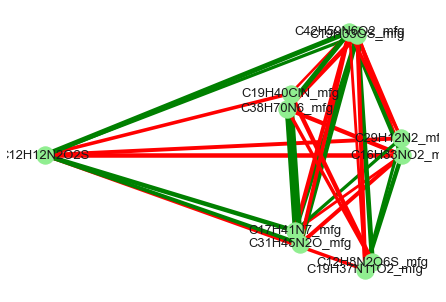

In [62]:
lineWidth = 5
nx.draw(g, pos = pos,
        edge_color=['red' if x < 0 else 'green' for x in subLinks_filtered['value']], 
        width= subLinks_filtered['value'] * lineWidth,
        with_labels=True,
        node_color='lightgreen',
        font_size=13)
plt.tight_layout()